In [1]:
import numpy as np
import pickle as pkl

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append("../functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)


In [2]:
source = "ERSST"

In [3]:
modelpath = "../models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead_tvtfolds"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)

filefront = experiment_dict["filename"]
filename = modelpath + filefront
ntrainvariants = experiment_dict["ntrainvariants"]
nvalvariants = experiment_dict["nvalvariants"]
ntestvariants = experiment_dict["ntestvariants"]
foldseeds = experiment_dict["foldseeds"]
seedlist = experiment_dict["seeds"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]

lon, lat = preprocessing.outlonxlat(experiment_dict)
nvars = int(nvalvariants*len(modellist))
centre = (outbounds[2]+outbounds[3])/2
nvariant = ntestvariants # check!
nmodels = len(modellist)
nmems = 30
obsyearvec = np.arange(1870+2*run+leadtime,2023,)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [4]:
data_experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
data_experiment_dict = experiment_settings.get_experiment_settings(data_experiment_name)
datafilefront = data_experiment_dict["filename"]
datafile = "../processed_data/" + datafilefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"] 

In [5]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelpearsons

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

In [6]:
trainvaltestfile = "../processed_data/foldseeds" + filefront + ".pkl"
with open(trainvaltestfile,'rb') as f:
    trainvaltestmat = pkl.load(f)

In [20]:
# Go through each CNN from each fold and find which initialization has the best skill on validation data, then use that for the comparison for each val fold.

modelscorr = np.empty((len(foldseeds),len(seedlist),nmodels,nvariant))
obscorr_ERSST = np.empty((len(foldseeds),len(seedlist)))
obscorr_HadISST = np.empty((len(foldseeds),len(seedlist)))

obstimeseries_ERSST_true = np.empty((len(foldseeds),len(seedlist),len(obsyearvec)))
obstimeseries_ERSST_pred = np.empty((len(foldseeds),len(seedlist),len(obsyearvec)))

obstimeseries_HadISST_true = np.empty((len(foldseeds),len(seedlist),len(obsyearvec)))
obstimeseries_HadISST_pred = np.empty((len(foldseeds),len(seedlist),len(obsyearvec)))

valmse = np.empty((len(foldseeds),len(seedlist)))

In [21]:
for ifold, foldseed in enumerate(foldseeds):
    
    np.random.seed(foldseed)
    memorder = trainvaltestmat[ifold]
    
    trainvaltest = [
                    memorder[:ntrainvariants],
                    memorder[ntrainvariants:(ntrainvariants+nvalvariants)],
                    memorder[(ntrainvariants+nvalvariants):]
                    ]
    
    inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
        allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])
    
    inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
    inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
    inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0
    
    outputstd = np.std(outputdata, axis=0, keepdims=True)
    outputdata = outputdata/outputstd
    outputval = outputval/outputstd
    outputtest = outputtest/outputstd
    
    outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
    outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
    outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0 
    
    ntimesteps = int(len(outputval)/(nvariant*nmodels))
    landmask = (np.mean(outputval,axis=0))!=0

    inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
    inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)
    
    inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
    inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)
    
    for iseed,random_seed in enumerate(seedlist):
    
        fileout = filename + "_seed=" + str(random_seed) + "_foldseed_" + str(foldseed) +".h5"
        
        full_model = build_model.build_CNN_full(inputval, outputval, 
                                                        experiment_dict, random_seed)   
        
        full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                           )
    
        full_model.load_weights(fileout)
        
        full_model.trainable = False # freeze BN
        
        y_pred_val = full_model.predict(inputval)
        y_pred_test = full_model.predict(inputtest,verbose=0)
        
        y_pred_ERSST = full_model.predict(inputobs_ERSST,verbose=0)
        y_pred_HadISST = full_model.predict(inputobs_HadISST,verbose=0)
        
        valmse[ifold,iseed] = weightedMSE(y_pred_val,outputval,latweights)
        
        bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)  

        modelscorr[ifold,iseed,:,:] = model_member_corr(bestpattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask)
        obscorr_ERSST[ifold,iseed],_ = allthelinalg.corr_indextimeseries(bestpattern,outputobs_ERSST,y_pred_ERSST,outputval,y_pred_val,landmask)
        obscorr_HadISST[ifold,iseed],_ = allthelinalg.corr_indextimeseries(bestpattern,outputobs_HadISST,y_pred_HadISST,outputval,y_pred_val,landmask)
        
        obstimeseries_ERSST_true[ifold,iseed,:] = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)
        obstimeseries_ERSST_pred[ifold,iseed,:] = allthelinalg.index_timeseries(y_pred_ERSST,bestpattern,landmask)

        obstimeseries_HadISST_true[ifold,iseed,:] = allthelinalg.index_timeseries(outputobs_HadISST,bestpattern,landmask)
        obstimeseries_HadISST_pred[ifold,iseed,:] = allthelinalg.index_timeseries(y_pred_HadISST,bestpattern,landmask)

conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conversion done
336/336 [==============================] - 1s 3ms/step
conver

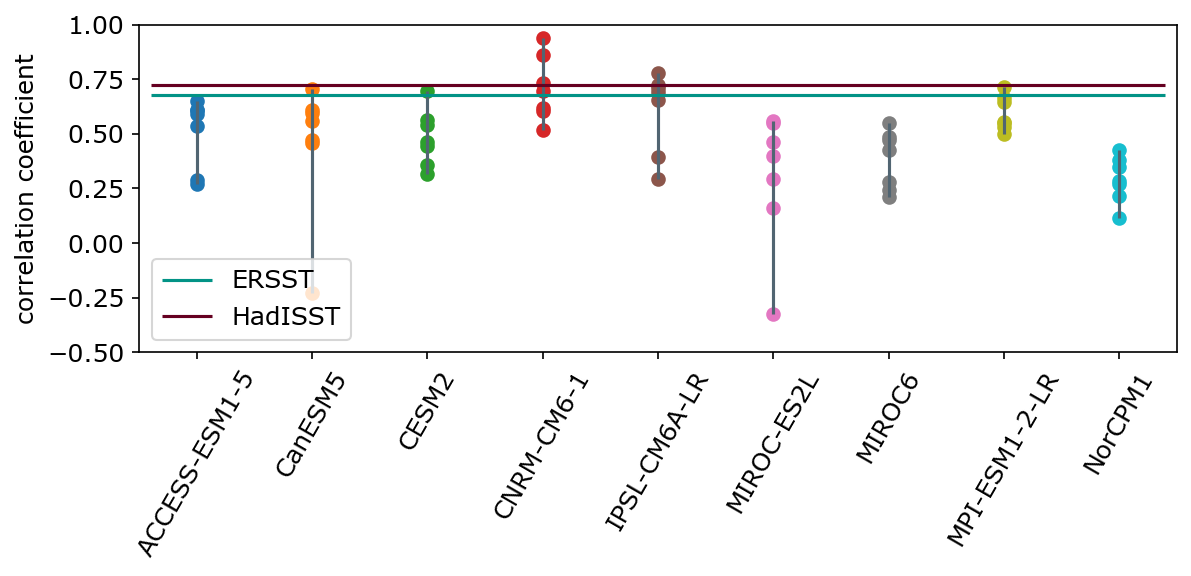

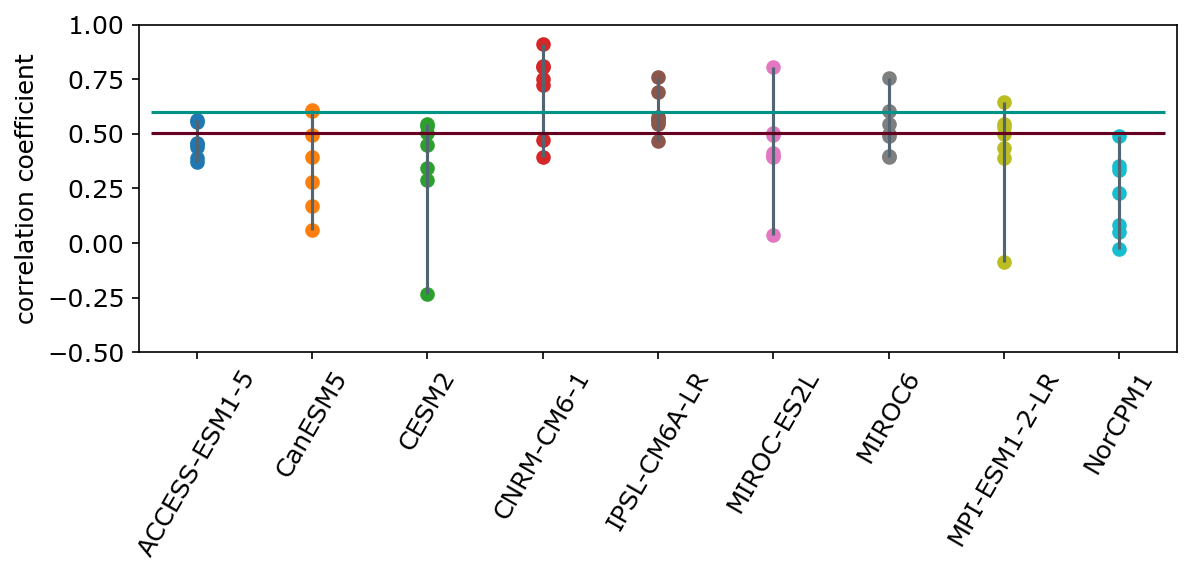

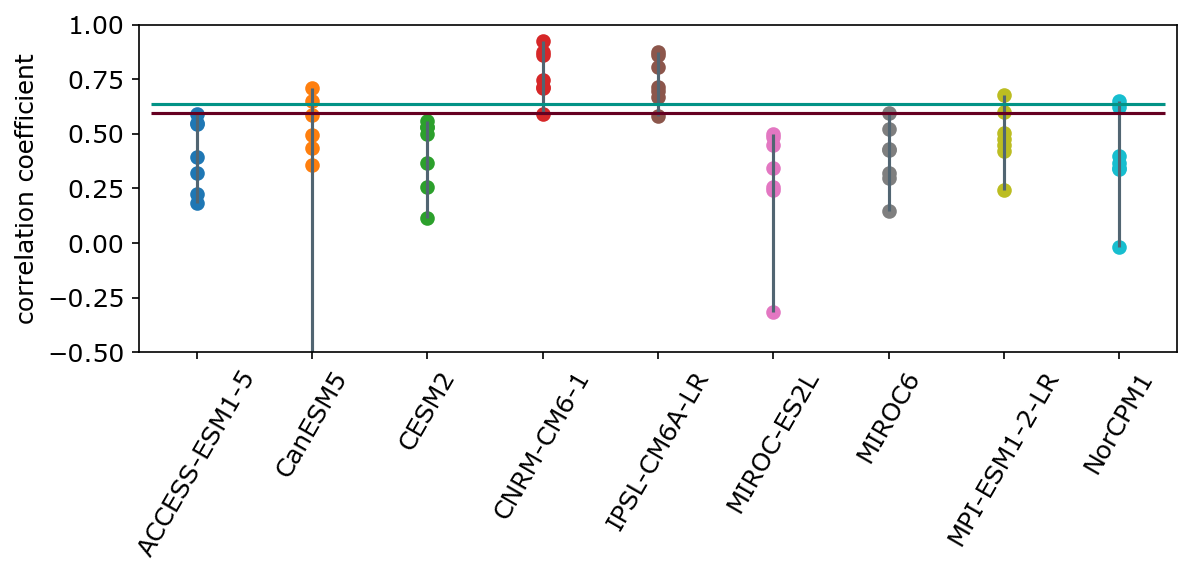

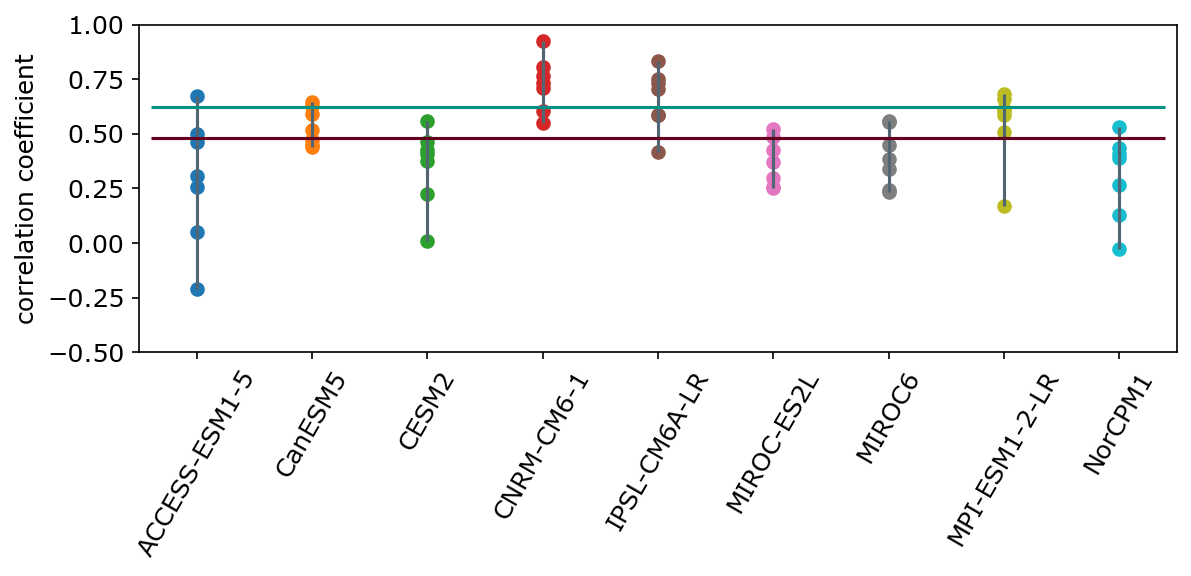

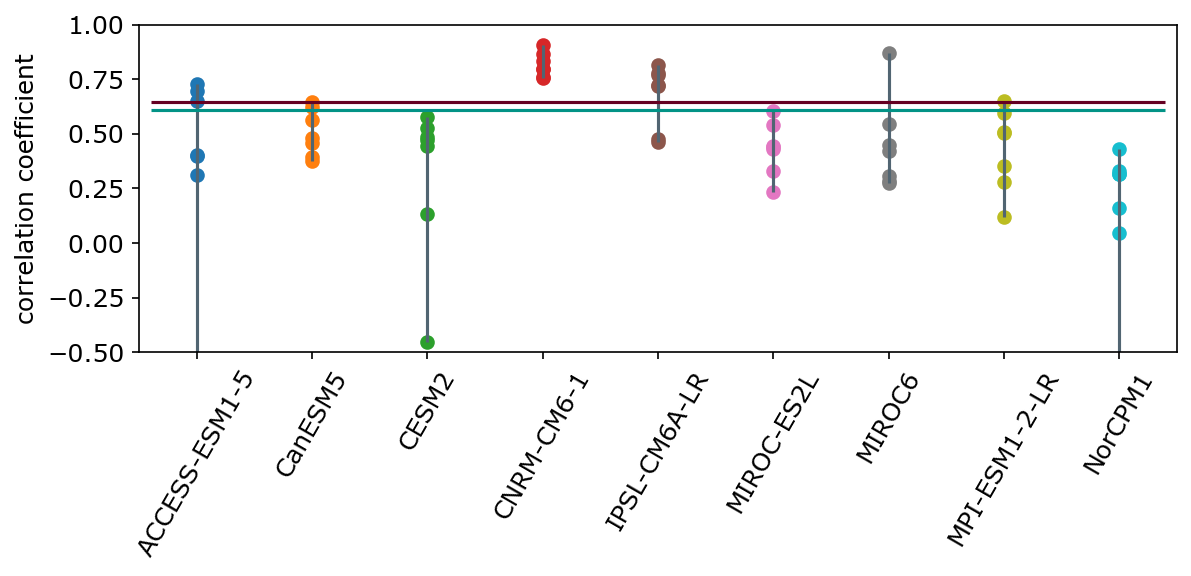

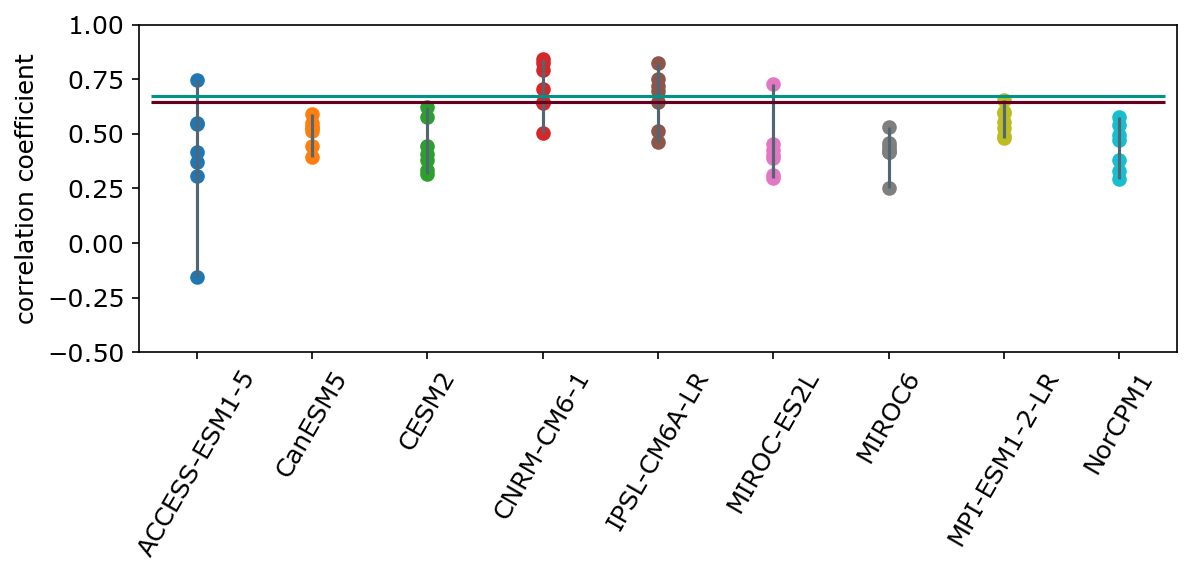

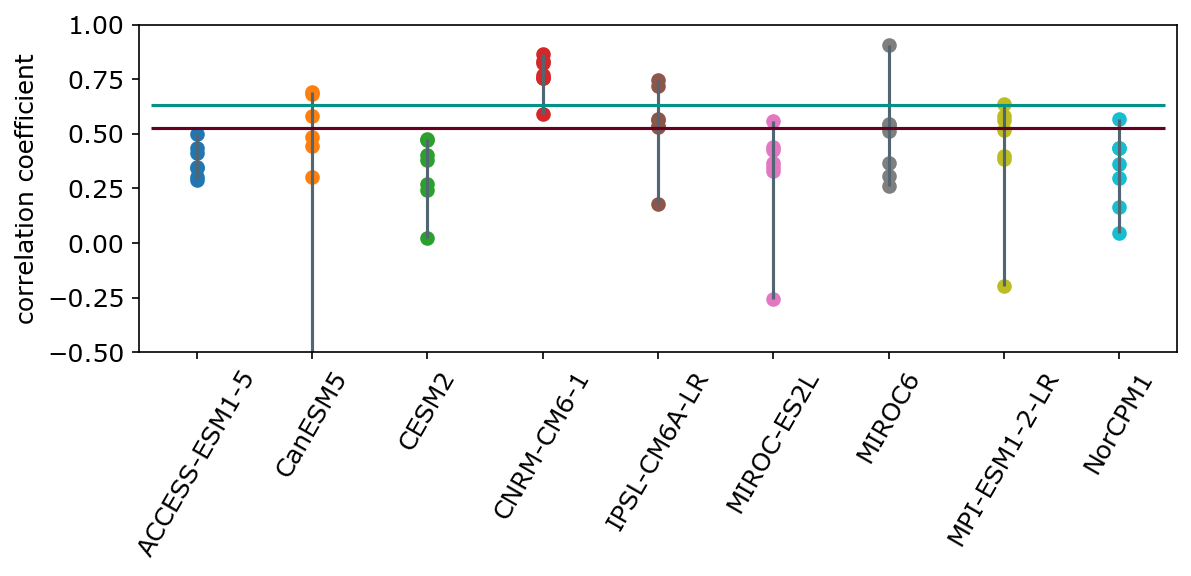

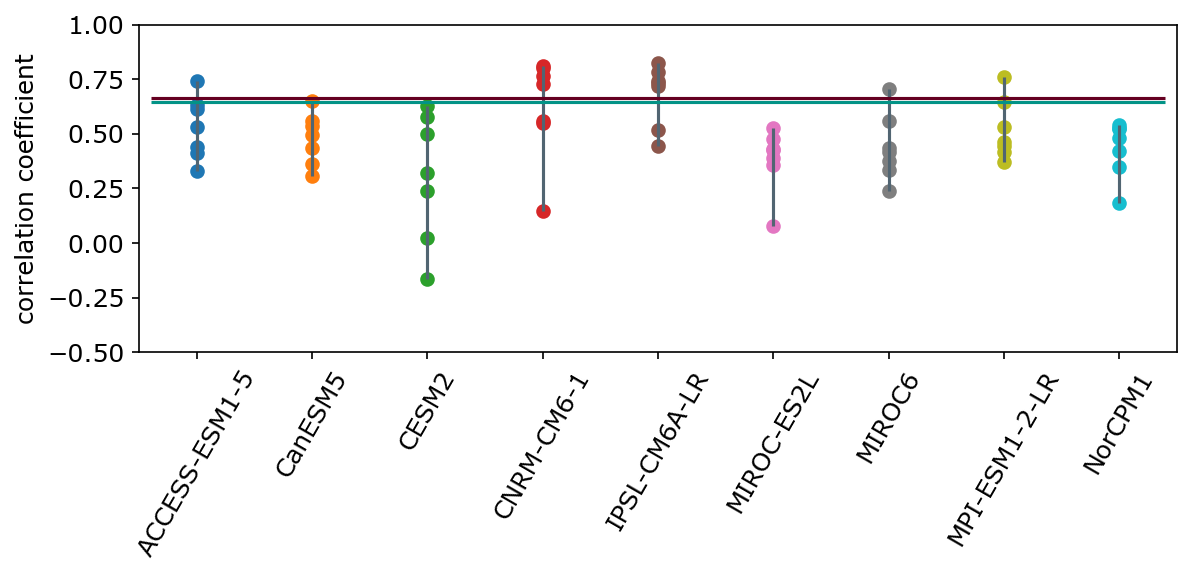

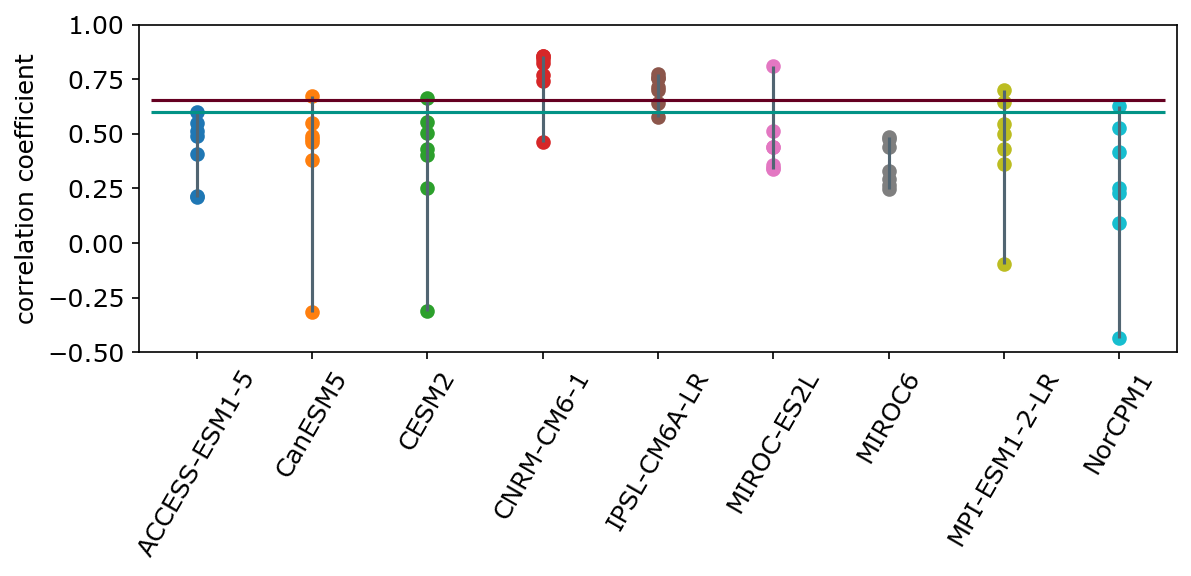

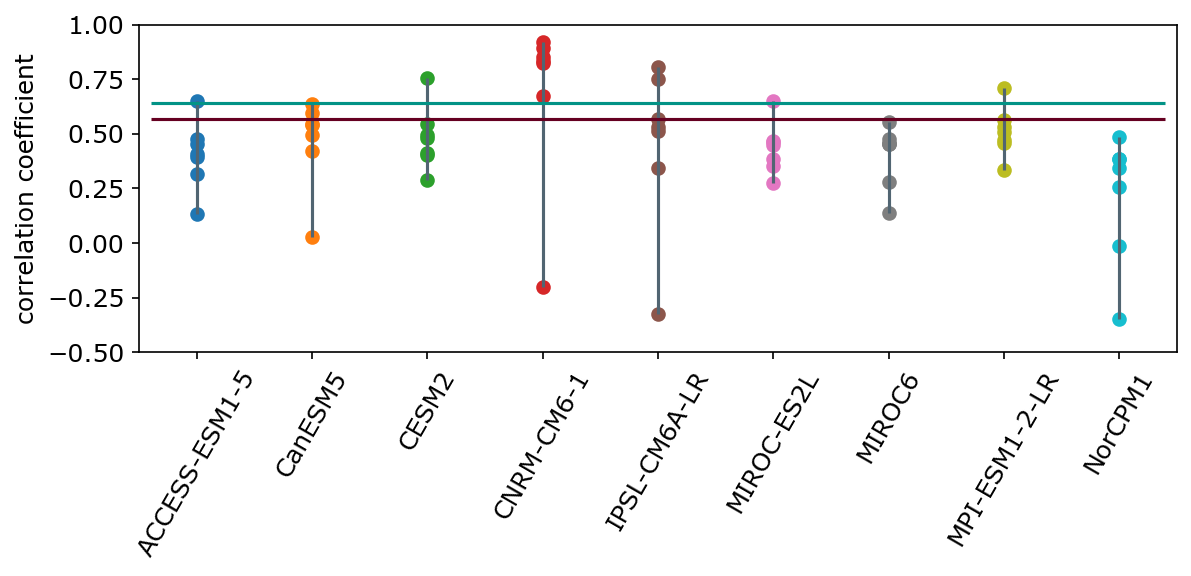

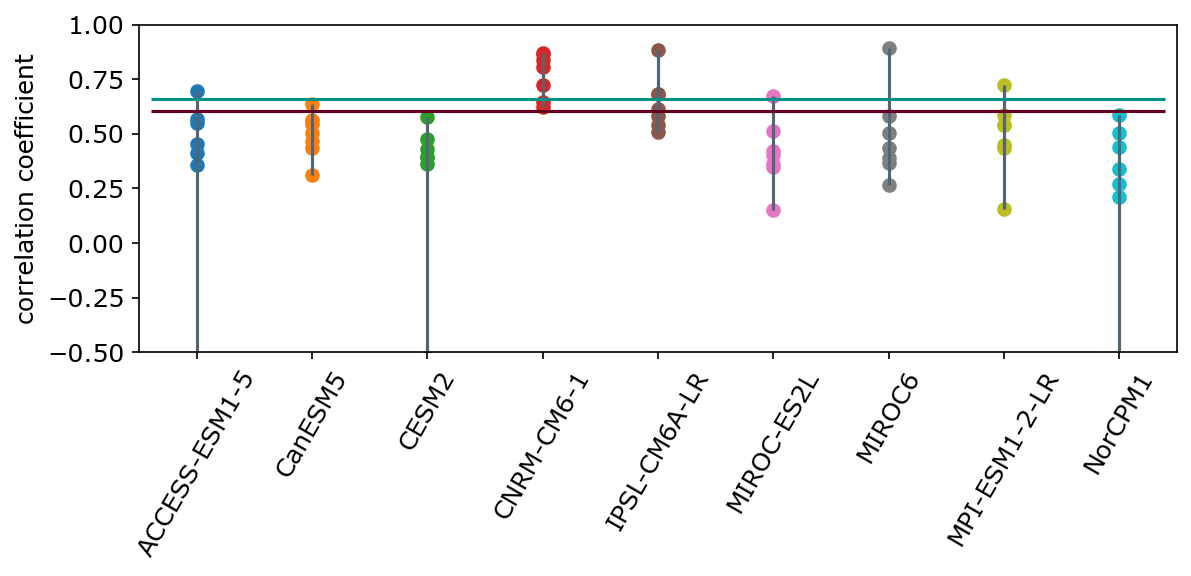

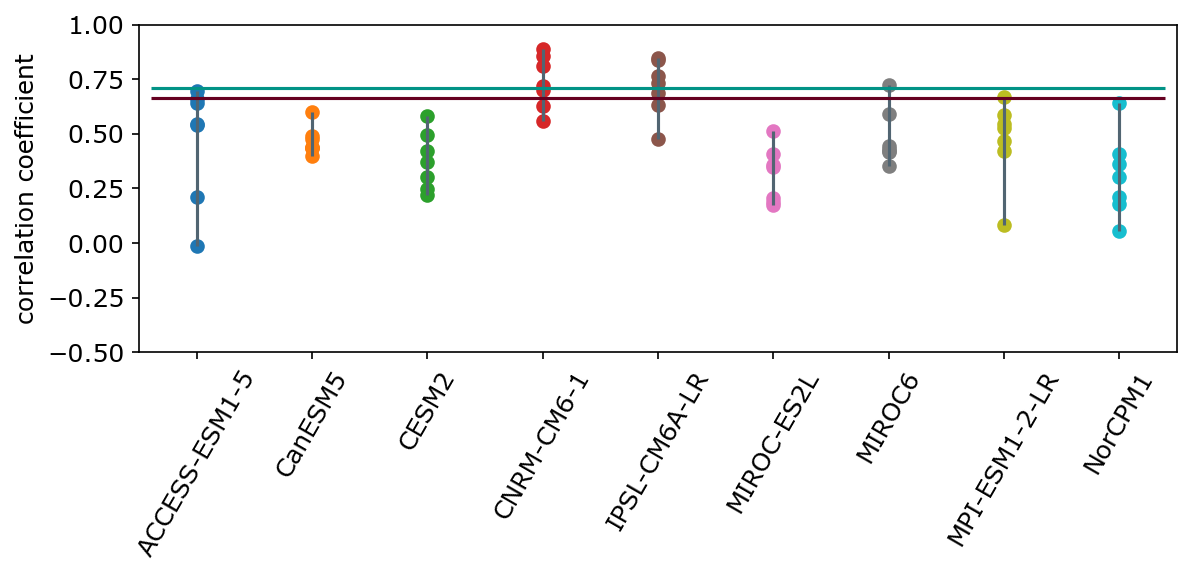

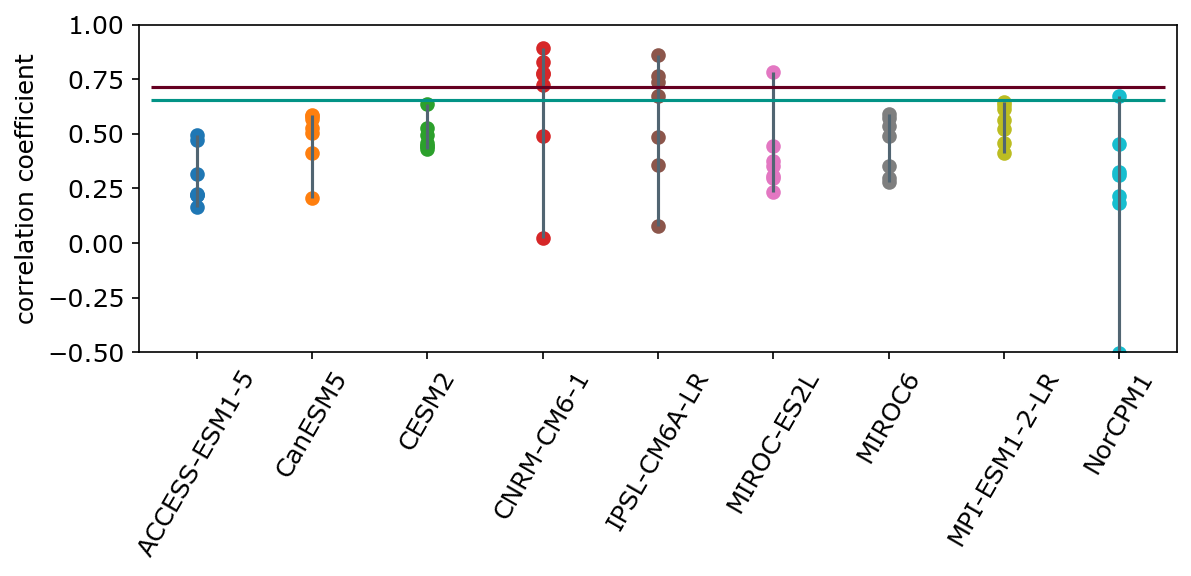

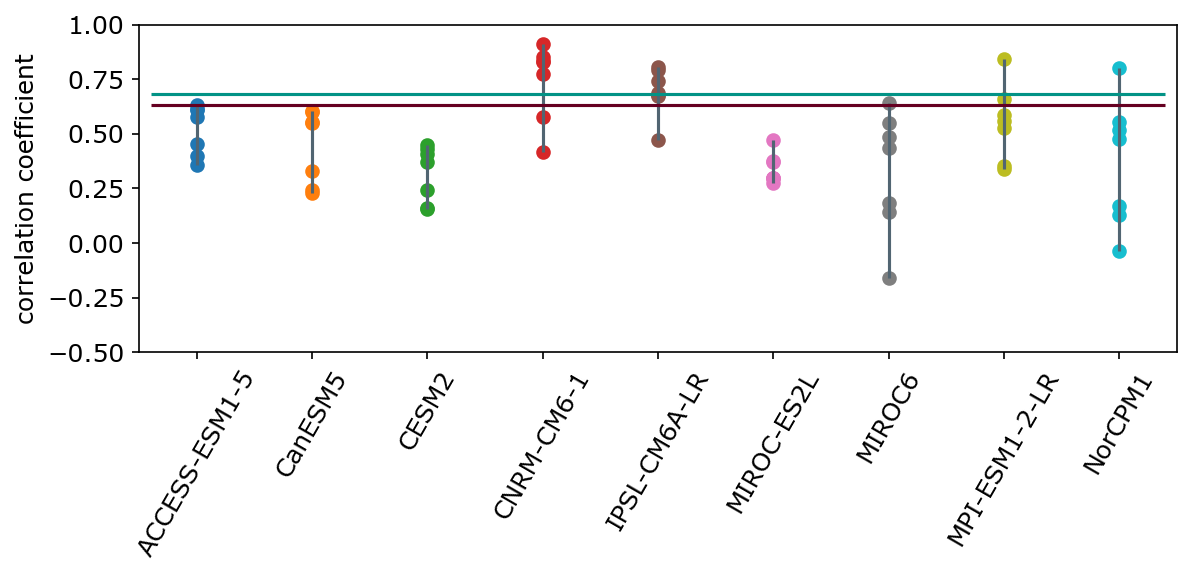

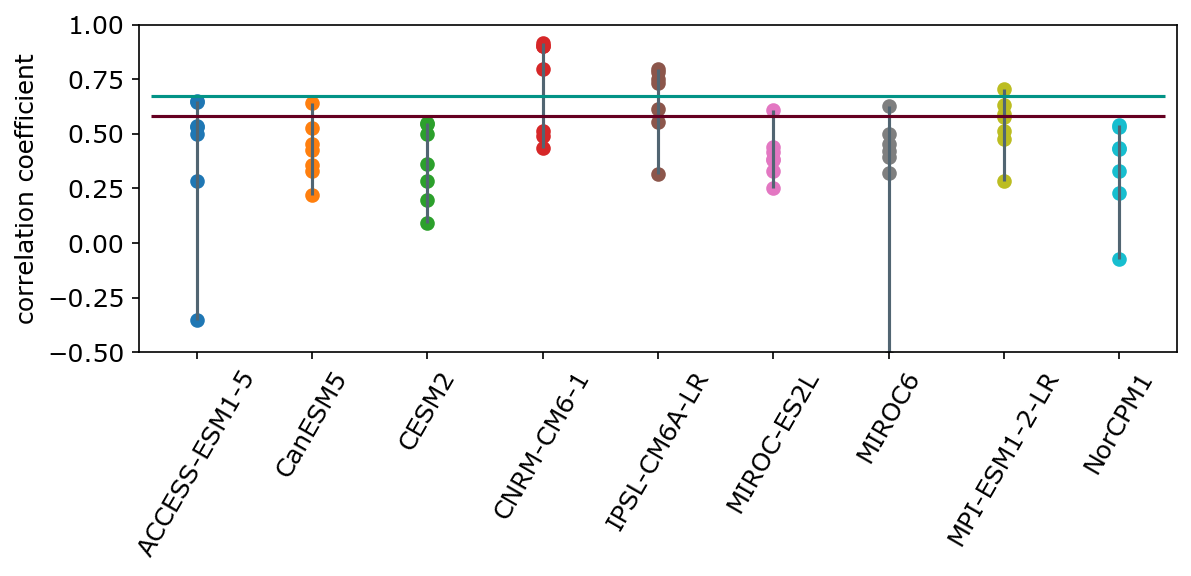

In [20]:
imp.reload(analysisplots)
bestseeds = np.argmin(valmse,axis=1)
sourcelist = ["ERSST","HadISST"]

savestr = "../figures/supp/tvt_"

for ifold in range(len(foldseeds)):
    if ifold ==0:
        legend=True
    else:
        legend = False
    strout = savestr + str(ifold) + ".png"
    analysisplots.prettyscatterplot_supp(modelscorr[ifold,bestseeds[ifold],:,:],[obscorr_ERSST[ifold,bestseeds[ifold]],
                                                                            obscorr_HadISST[ifold,bestseeds[ifold]]],
                                    modellist,np.arange(ntestvariants),"correlation coefficient",sourcelist,strout,legend)

In [31]:
imp.reload(analysisplots)

besttimeseries_ERSST_pred = np.empty((len(foldseeds),obstimeseries_ERSST_pred.shape[2]))
besttimeseries_ERSST_true = np.empty((len(foldseeds),obstimeseries_ERSST_pred.shape[2]))

besttimeseries_HadISST_pred = np.empty((len(foldseeds),obstimeseries_HadISST_pred.shape[2]))
besttimeseries_HadISST_true = np.empty((len(foldseeds),obstimeseries_HadISST_pred.shape[2]))

bestseeds = np.argmin(valmse,axis=1)

for ifold in range(len(foldseeds)):
    
    besttimeseries_HadISST_pred[ifold,:] = obstimeseries_HadISST_pred[ifold,bestseeds[ifold],:]
    besttimeseries_HadISST_true[ifold,:] = obstimeseries_HadISST_true[ifold,bestseeds[ifold],:]

    besttimeseries_ERSST_pred[ifold,:] = obstimeseries_ERSST_pred[ifold,bestseeds[ifold],:]
    besttimeseries_ERSST_true[ifold,:] = obstimeseries_ERSST_true[ifold,bestseeds[ifold],:]



In [32]:
np.min(obstimeseries_ERSST_pred)

-3.243237129651051

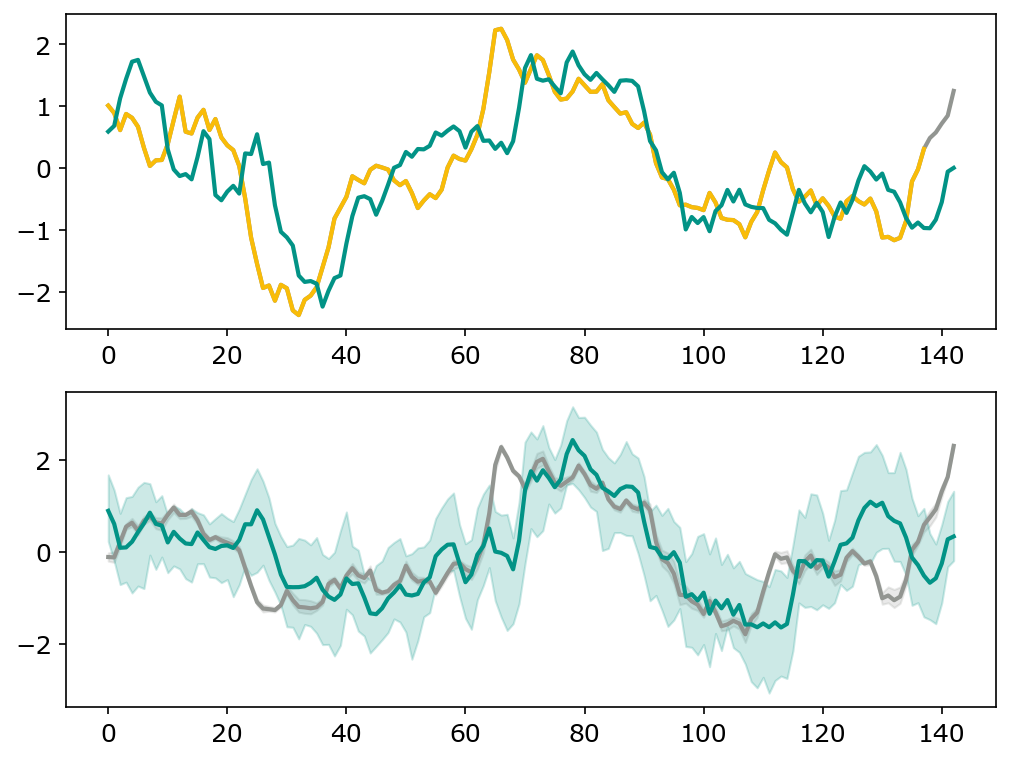

In [42]:
xvec = np.arange(obstimeseries_ERSST_pred.shape[2])

maxpred_ERSST = np.max(obstimeseries_ERSST_pred,axis=(0,1))
minpred_ERSST = np.min(obstimeseries_ERSST_pred,axis=(0,1))

maxtrue_ERSST = np.max(obstimeseries_ERSST_true,axis=(0,1))
mintrue_ERSST = np.min(obstimeseries_ERSST_true,axis=(0,1))

maxpred_HadISST = np.max(obstimeseries_HadISST_pred,axis=(0,1))
minpred_HadISST = np.min(obstimeseries_HadISST_pred,axis=(0,1))

maxtrue_HadISST = np.max(obstimeseries_HadISST_true,axis=(0,1))
mintrue_HadISST = np.min(obstimeseries_HadISST_true,axis=(0,1))


plt.figure(figsize=(8,6))

plt.subplot(2,1,1)

# plt.fill_between(xvec,mintrue_ERSST,maxtrue_ERSST,color='xkcd:grey',alpha=0.2)
# plt.fill_between(xvec,minpred_ERSST,maxpred_ERSST,color='xkcd:teal',alpha=0.2)

plt.plot(np.mean(besttimeseries_ERSST_true,axis=0),color='xkcd:grey',linewidth=2)
plt.plot(np.mean(besttimeseries_ERSST_pred,axis=0),color='xkcd:teal',linewidth=2)

# plt.plot(xvec,np.mean(besttimeseries_ERSST_true,axis=0),color='xkcd:grey',linewidth=2)
# plt.plot(xvec,besttimeseries_ERSST_pred.transpose(),color='xkcd:teal',linewidth=0.1)


plt.subplot(2,1,2)

plt.fill_between(xvec,mintrue_HadISST,maxtrue_HadISST,color='xkcd:grey',alpha=0.2)
plt.fill_between(xvec,minpred_HadISST,maxpred_HadISST,color='xkcd:teal',alpha=0.2)

plt.plot(xvec,np.mean(besttimeseries_HadISST_true,axis=0),color='xkcd:grey',linewidth=2)
plt.plot(xvec,np.mean(besttimeseries_HadISST_pred,axis=0),color='xkcd:teal',linewidth=2)

plt.show()

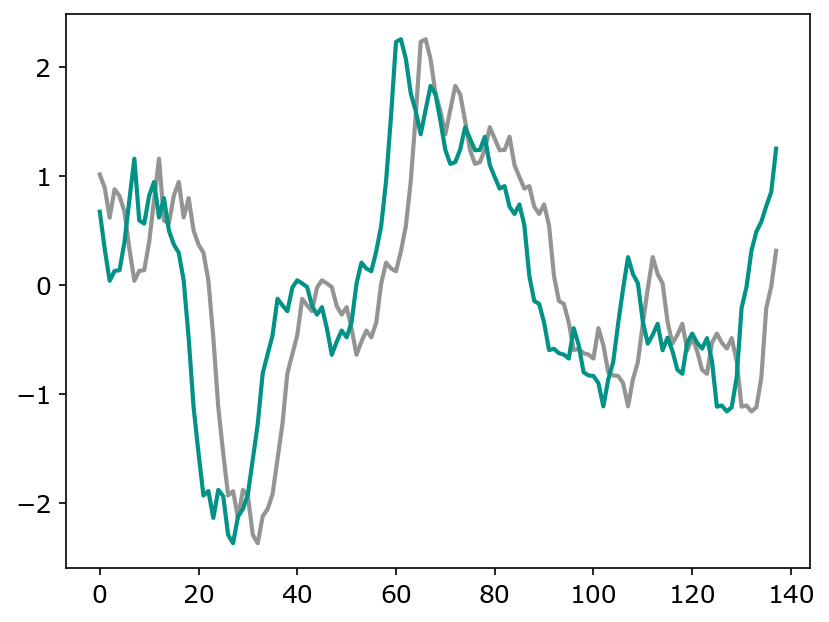

In [51]:
from scipy.stats import pearsonr

plt.plot(np.mean(besttimeseries_ERSST_true,axis=0)[:-5],color='xkcd:grey',linewidth=2)
plt.plot(np.mean(besttimeseries_ERSST_true,axis=0)[5:],color='xkcd:teal',linewidth=2)

# a=pearsonr(np.mean(besttimeseries_ERSST_true,axis=0)[:-5],np.mean(besttimeseries_ERSST_true,axis=0)[5:])
# print(a)

a = np.mean((np.mean(besttimeseries_ERSST_true,axis=0)[:-5]-np.mean(besttimeseries_ERSST_true,axis=0)[5:])**2)
b = np.mean((np.mean(besttimeseries_ERSST_true,axis=0)-np.mean(besttimeseries_ERSST_pred,axis=0))**2)

0.605791125134379